## NIPS CM and PLS Spin Test 

### Imports

In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
from env.imports import *

In [24]:
import importlib
import data

import data.data_utils
from data.data_load import load_transcriptome, load_connectome, load_coords
from data.data_viz import plot_connectome, plot_connectome_with_labels, plot_transcriptome
from models import *
from data import * 
from sim import *

import models
import models.metrics
from models.metrics import *

from sim.null import fit_cm, fit_cm_closed, fit_cm_closed_with_scalar_bias, fit_cm_closed_with_gcv, grid_search_alpha_with_gcv
from sim.null import get_best_pls_model, run_spin_test, run_spin_test_random, run_spin_test_precomputed_colored


## Specify connectome and transcriptome

Assign features and targets

In [25]:
# S400
X = load_transcriptome(parcellation='S400', omit_subcortical=False, hemisphere='both', impute_strategy='mirror_interpolate', sort_genes='expression')
X_pca = load_transcriptome(parcellation='S400', run_PCA=True, omit_subcortical=False, hemisphere='both', impute_strategy='mirror_interpolate', sort_genes='expression')
Y_sc = load_connectome(parcellation='S400', omit_subcortical=False, measure='SC', hemisphere='both', include_labels=False)
Y_fc, region_labels, lh_indices, rh_indices = load_connectome(parcellation='S400', omit_subcortical=False, measure='FC', hemisphere='both', include_labels=True)
Y = Y_fc
coords = load_coords(parcellation='S400', omit_subcortical=True, hemisphere='both')

# Find rows that are not all NaN - necessary for gene expression data with unsampled regions
valid_indices = ~np.isnan(X).all(axis=1)

# Subset all data using valid indices
X = X[valid_indices]
X_pca = X_pca[valid_indices]
Y = Y[valid_indices][:, valid_indices]


Number of components for 95% variance PCA: 27


## Find Best True Fit SCM model

alpha=0      | GCV=1.1322e-07 | Residual=6.9415e+01 | τ=206296.00 | Tr(H)=729.00
alpha=1e-05  | GCV=1.1322e-07 | Residual=6.9415e+01 | τ=206296.00 | Tr(H)=729.00
alpha=0.0001 | GCV=1.1322e-07 | Residual=6.9415e+01 | τ=206296.00 | Tr(H)=729.00
alpha=0.001  | GCV=1.1322e-07 | Residual=6.9415e+01 | τ=206296.01 | Tr(H)=728.99
alpha=0.01   | GCV=1.1322e-07 | Residual=6.9415e+01 | τ=206296.06 | Tr(H)=728.94
alpha=0.1    | GCV=1.1322e-07 | Residual=6.9415e+01 | τ=206296.65 | Tr(H)=728.35
alpha=1      | GCV=1.1321e-07 | Residual=6.9415e+01 | τ=206302.44 | Tr(H)=722.56
alpha=10     | GCV=1.1332e-07 | Residual=6.9465e+01 | τ=206355.23 | Tr(H)=669.77
alpha=100    | GCV=1.1874e-07 | Residual=7.1201e+01 | τ=206630.65 | Tr(H)=394.35


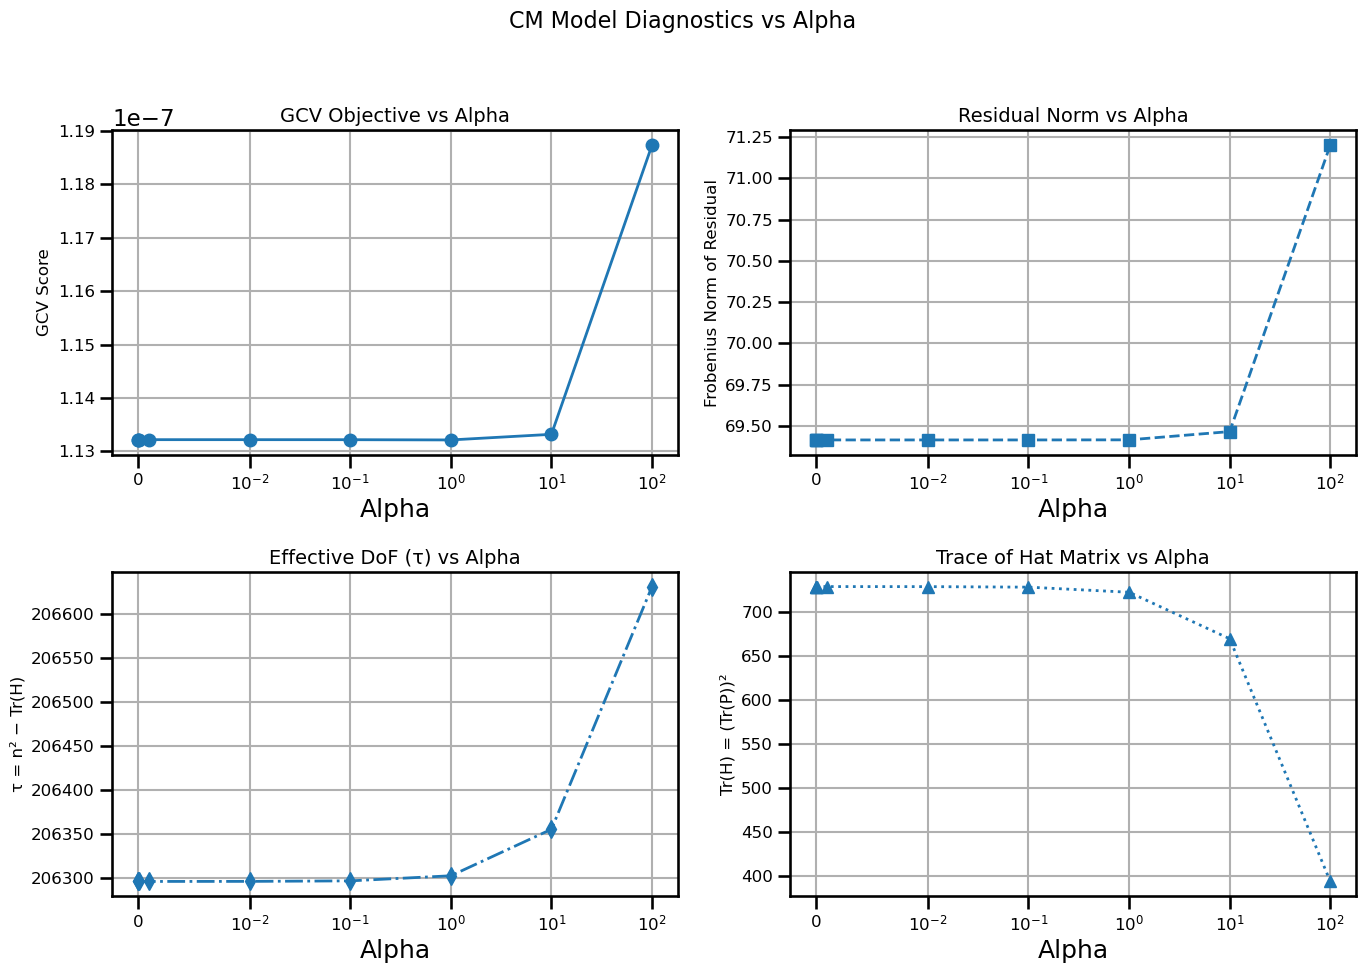

In [26]:
# # Define alpha values and run search
alphas = [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
results = grid_search_alpha_with_gcv(X_pca, Y, alphas)


CM model metrics:
Pearson r: 0.560
R-squared: 0.30452
MSE: 0.02327


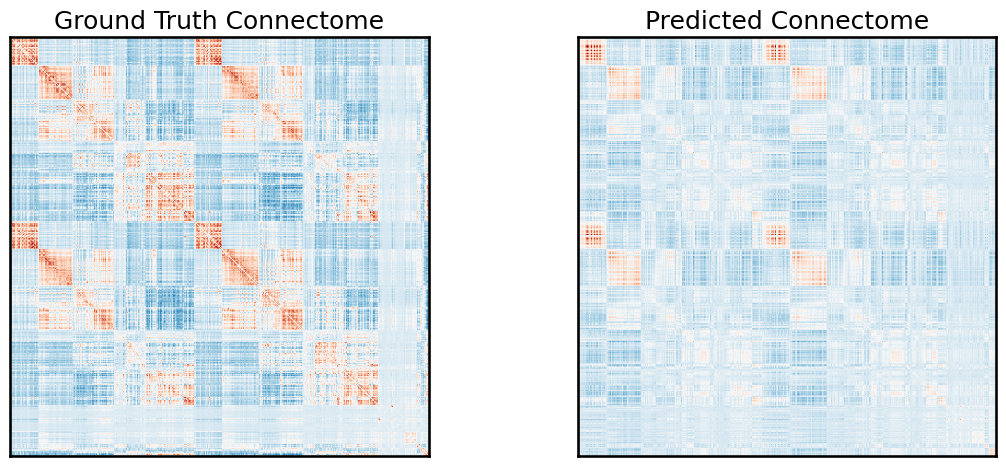

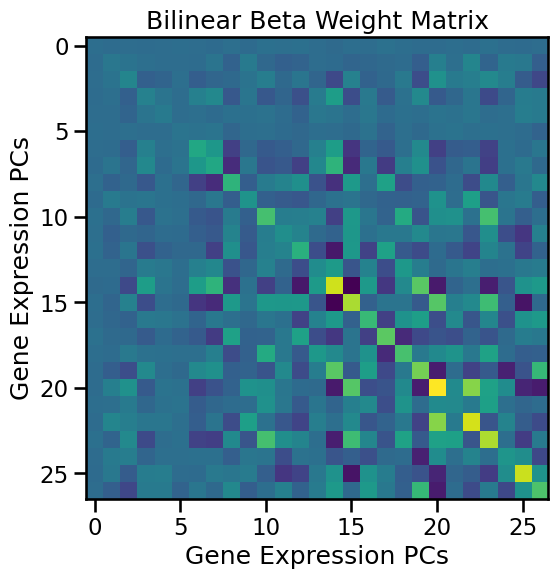

In [27]:
O, Y_pred = fit_cm_closed(X_pca, Y, alpha=0.1, plot=True)


CM model metrics:
Pearson r: 0.560
R-squared: 0.31329
MSE: 0.02298


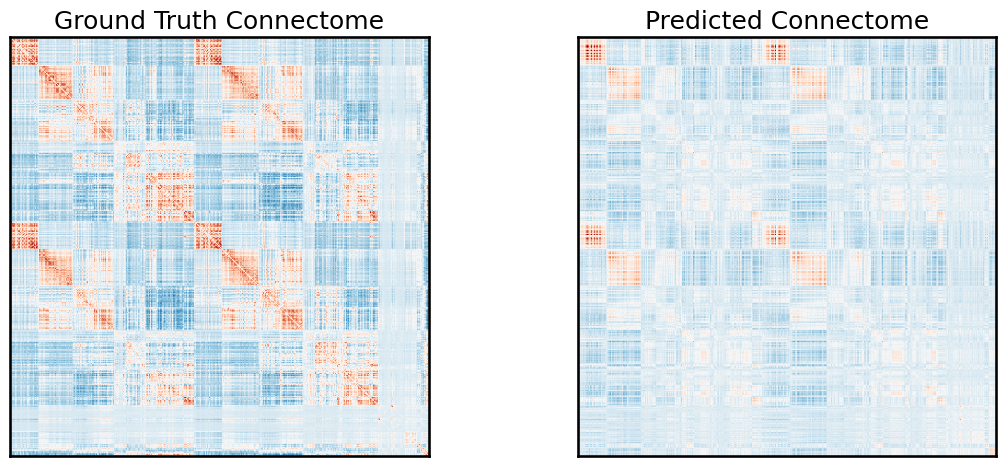

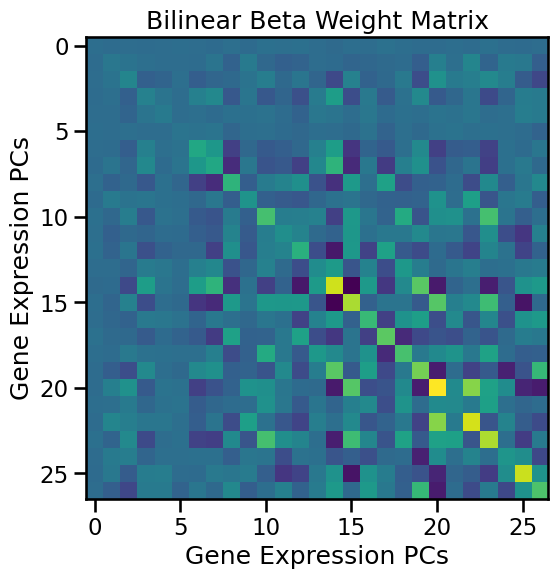

In [28]:
O, b, Y_pred = fit_cm_closed_with_scalar_bias(X_pca, Y, alpha=0.1, plot=True)

## Fit Best True PLS Model

5
10
15
20
25


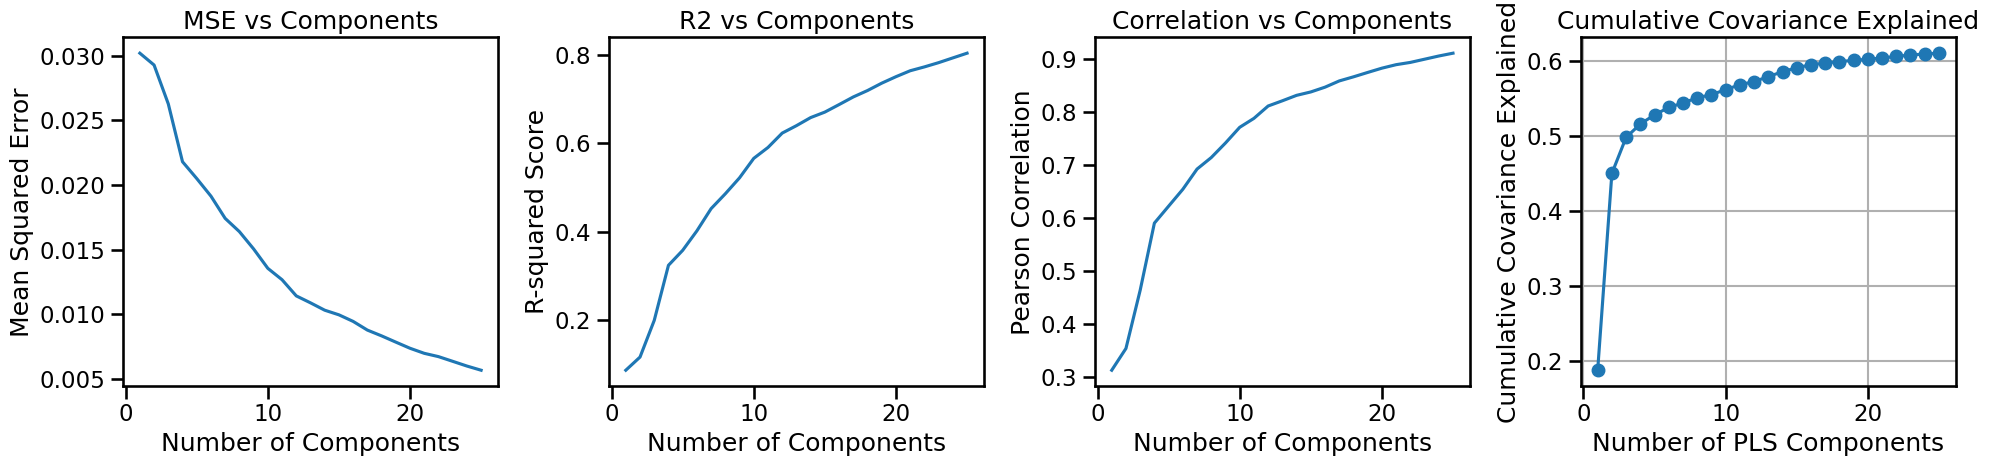

Best model performance (at elbow point):
Number of components: 9
MSE: 0.0151
R2: 0.5219
Mean correlation: 0.7416


In [29]:
best_pls_model, metrics = get_best_pls_model(X, Y, max_components=25)

## Comparison to null spin tests

In [30]:
spins_df_1k = pd.read_csv('./data/enigma/1000_null_spins.csv')
spins_df_10k = pd.read_csv('./data/enigma/10000_null_spins.csv')
spins_df_spatial_random = pd.read_csv('./data/enigma/1000_spatial_random_spins.csv')
spins_df_random = pd.read_csv('./data/enigma/1000_true_random_spins.csv')
spins_df_10k.head()

,cortical_spins,subcortical_spins,cortical_cost,subcortical_cost,total_cost,mean_error_rank,total_cost_rank,SA_error_rank,poly_error_rank,standardized_SA_error,...,poly_a1,poly_a2,poly_a3,poly_a4,poly_a1_PCA,poly_a2_PCA,poly_a3_PCA,poly_a4_PCA,pearsonr_SCM,pearsonr_PLS
0,"[1, 6, 4, 0, 2, 69, 12, 68, 5, 3, 10, 7, 15, 1...","[0, 33, 2, 29, 1, 5, 6, 7, 8, 3, 10, 11, 12, 1...",9868.096901,612.102793,10480.199694,16.666667,8.0,4.0,38.0,0.609384,...,1.096968,-0.028375,0.000318,-0.000001,1.049116,-0.032066,0.000341,-0.000001,0.364000,0.666082
1,"[21, 15, 193, 191, 190, 194, 19, 143, 144, 189...","[2, 9, 13, 12, 5, 6, 52, 49, 33, 7, 48, 10, 32...",9643.503872,1295.744937,10939.248809,151.666667,13.0,374.0,68.0,1.591515,...,1.061321,-0.028272,0.000327,-0.000001,1.052804,-0.034917,0.000388,-0.000001,0.344534,0.654514
2,"[122, 6, 3, 1, 4, 69, 12, 0, 2, 9, 10, 7, 19, ...","[31, 48, 47, 52, 46, 28, 30, 34, 7, 51, 10, 49...",10587.258836,3044.556141,13631.814976,152.333333,441.0,6.0,10.0,0.621569,...,1.082026,-0.029022,0.000340,-0.000001,1.050206,-0.032869,0.000358,-0.000001,0.345113,0.635034
3,"[175, 172, 137, 117, 170, 136, 113, 138, 134, ...","[53, 55, 46, 49, 54, 48, 5, 33, 4, 51, 32, 31,...",9722.312520,2569.249866,12291.562385,181.666667,82.0,340.0,123.0,1.547915,...,1.074919,-0.030991,0.000379,-0.000001,1.043412,-0.034916,0.000391,-0.000001,0.356331,0.627593
4,"[0, 1, 2, 6, 4, 5, 12, 7, 8, 3, 9, 11, 15, 92,...","[53, 55, 54, 48, 49, 50, 13, 9, 6, 52, 2, 47, ...",8802.011771,2648.851327,11450.863098,215.333333,26.0,5.0,615.0,0.609793,...,1.025928,-0.025585,0.000291,-0.000001,0.997005,-0.028756,0.000293,-0.000001,0.390174,0.679359


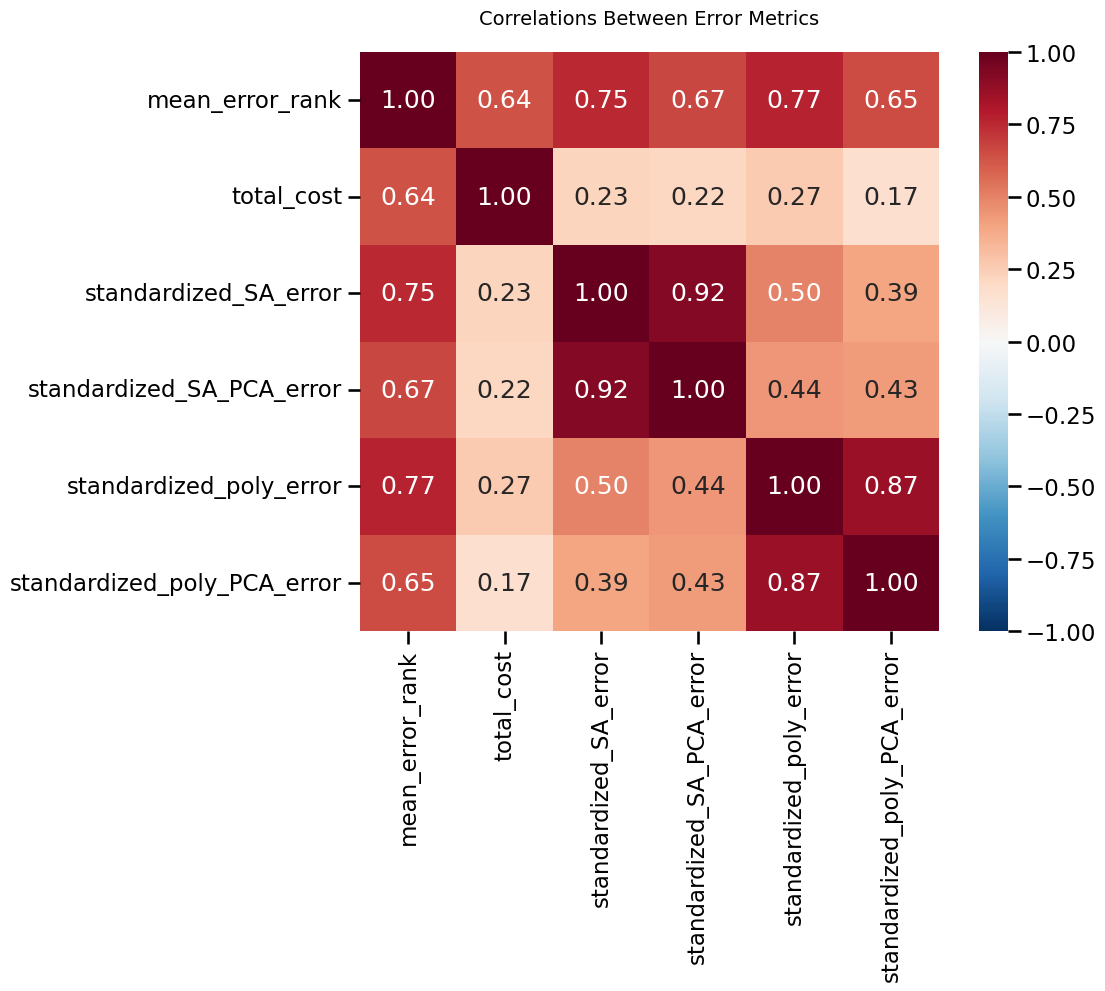

In [31]:
# Calculate correlations between error metrics
error_columns = ['mean_error_rank', 'total_cost', 'standardized_SA_error', 'standardized_SA_PCA_error', 
                'standardized_poly_error', 'standardized_poly_PCA_error']

# Compute correlation matrix
corr_matrix = spins_df_1k[error_columns].corr()

# Create figure
plt.figure(figsize=(12,10))

# Plot heatmap
sns.heatmap(corr_matrix, 
            annot=True, # Show correlation values
            cmap='RdBu_r', # Red-Blue diverging colormap
            vmin=-1, vmax=1, # Fix scale from -1 to 1
            center=0, # Center colormap at 0
            square=True, # Make cells square
            fmt='.2f') # Round correlation values to 2 decimal places

plt.title('Correlations Between Error Metrics', fontsize=14, pad=20)
plt.tight_layout()
plt.show()




Fit spatial null model: 

- Idea is that autocorrelation in gene expression, X, may drive the model solution
- To address this we can generate a spatial permutation of either the gene expression data or the connectome data and refit the model
- Here we will permute the target data as in Hansen, 2021

- The spin test embodies the null hypothesis that genes and connectivity values are spatially correlated with each other because of inherent spatial autocorrelation.
- In Hansen, 2021, the P value is computed as the proportion of null singular values that are greater in magnitude than the empirical singular values.
- Thus, the P value represents the probability that the observed spatial correspondence between genes and connectivity values could occur by randomly correlating maps with comparable spatial autocorrelation

- In our case the null distribution could be the pearson-r values (or other metrics) of the best model as determined by elbow point.


Quick reload in data subsetting for valid indices

In [40]:
# S400
X = load_transcriptome(parcellation='S400', omit_subcortical=False, hemisphere='both', impute_strategy='mirror_interpolate', sort_genes='expression')
X_pca = load_transcriptome(parcellation='S400', run_PCA=True, omit_subcortical=False, hemisphere='both', impute_strategy='mirror_interpolate', sort_genes='expression')
Y_sc = load_connectome(parcellation='S400', omit_subcortical=False, measure='SC', hemisphere='both', include_labels=False)
Y_fc, region_labels, lh_indices, rh_indices = load_connectome(parcellation='S400', omit_subcortical=False, measure='FC', hemisphere='both', include_labels=True)
Y = Y_fc
coords = load_coords(parcellation='S400', omit_subcortical=True, hemisphere='both')

# Find rows that are not all NaN - necessary for gene expression data with unsampled regions
valid_indices = ~np.isnan(X).all(axis=1)

# Subset all data using valid indices
X = X[valid_indices]
X_pca = X_pca[valid_indices]
Y = Y[valid_indices][:, valid_indices]

Number of components for 95% variance PCA: 27


permutation: 0
permutation: 50


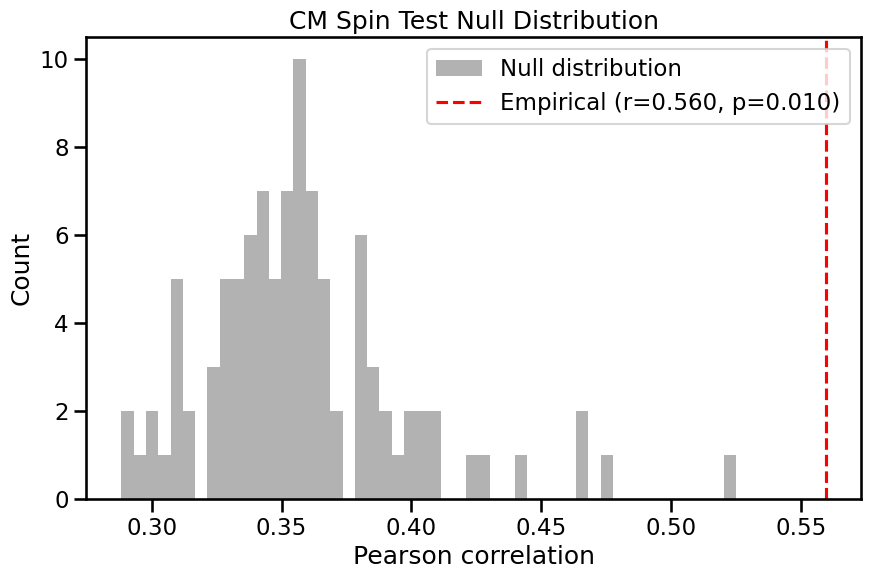

In [41]:
empirical_corr, p_value, null_distribution = run_spin_test(
    X=X_pca,
    valid_indices=valid_indices,
    Y_true=Y,
    spins_df=spins_df_10k,
    model_type='CM',
    sort_spins='mean_error_rank',
    n_perms=100
)

permutation: 0
permutation: 50


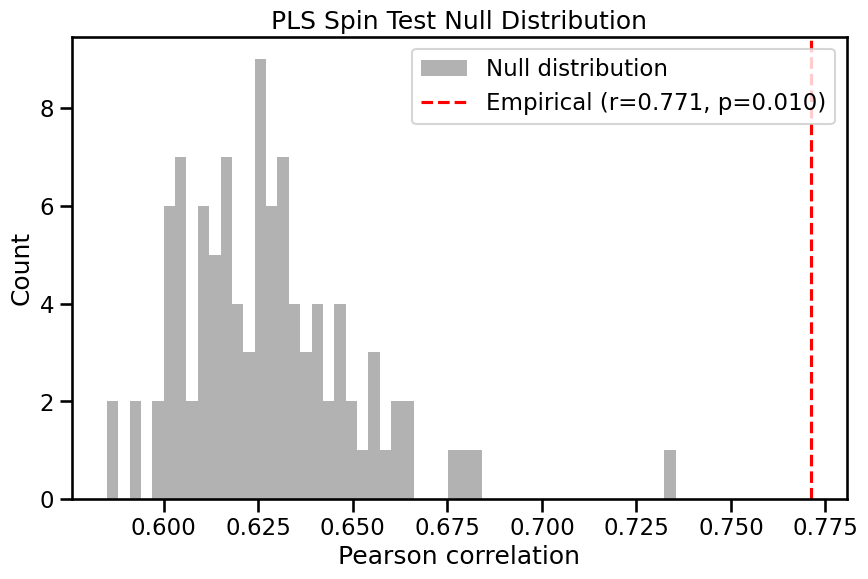

In [42]:
empirical_corr, p_value, null_distribution = run_spin_test(
    X=X,
    valid_indices=valid_indices,
    Y_true=Y, 
    spins_df=spins_df_10k,
    model_type='PLS',
    num_components=10,
    sort_spins='mean_error_rank',
    n_perms=100
)

permutation: 0
permutation: 50
permutation: 100
permutation: 150
permutation: 200
permutation: 250
permutation: 300
permutation: 350
permutation: 400
permutation: 450
permutation: 500
permutation: 550
permutation: 600
permutation: 650
permutation: 700
permutation: 750
permutation: 800
permutation: 850
permutation: 900
permutation: 950


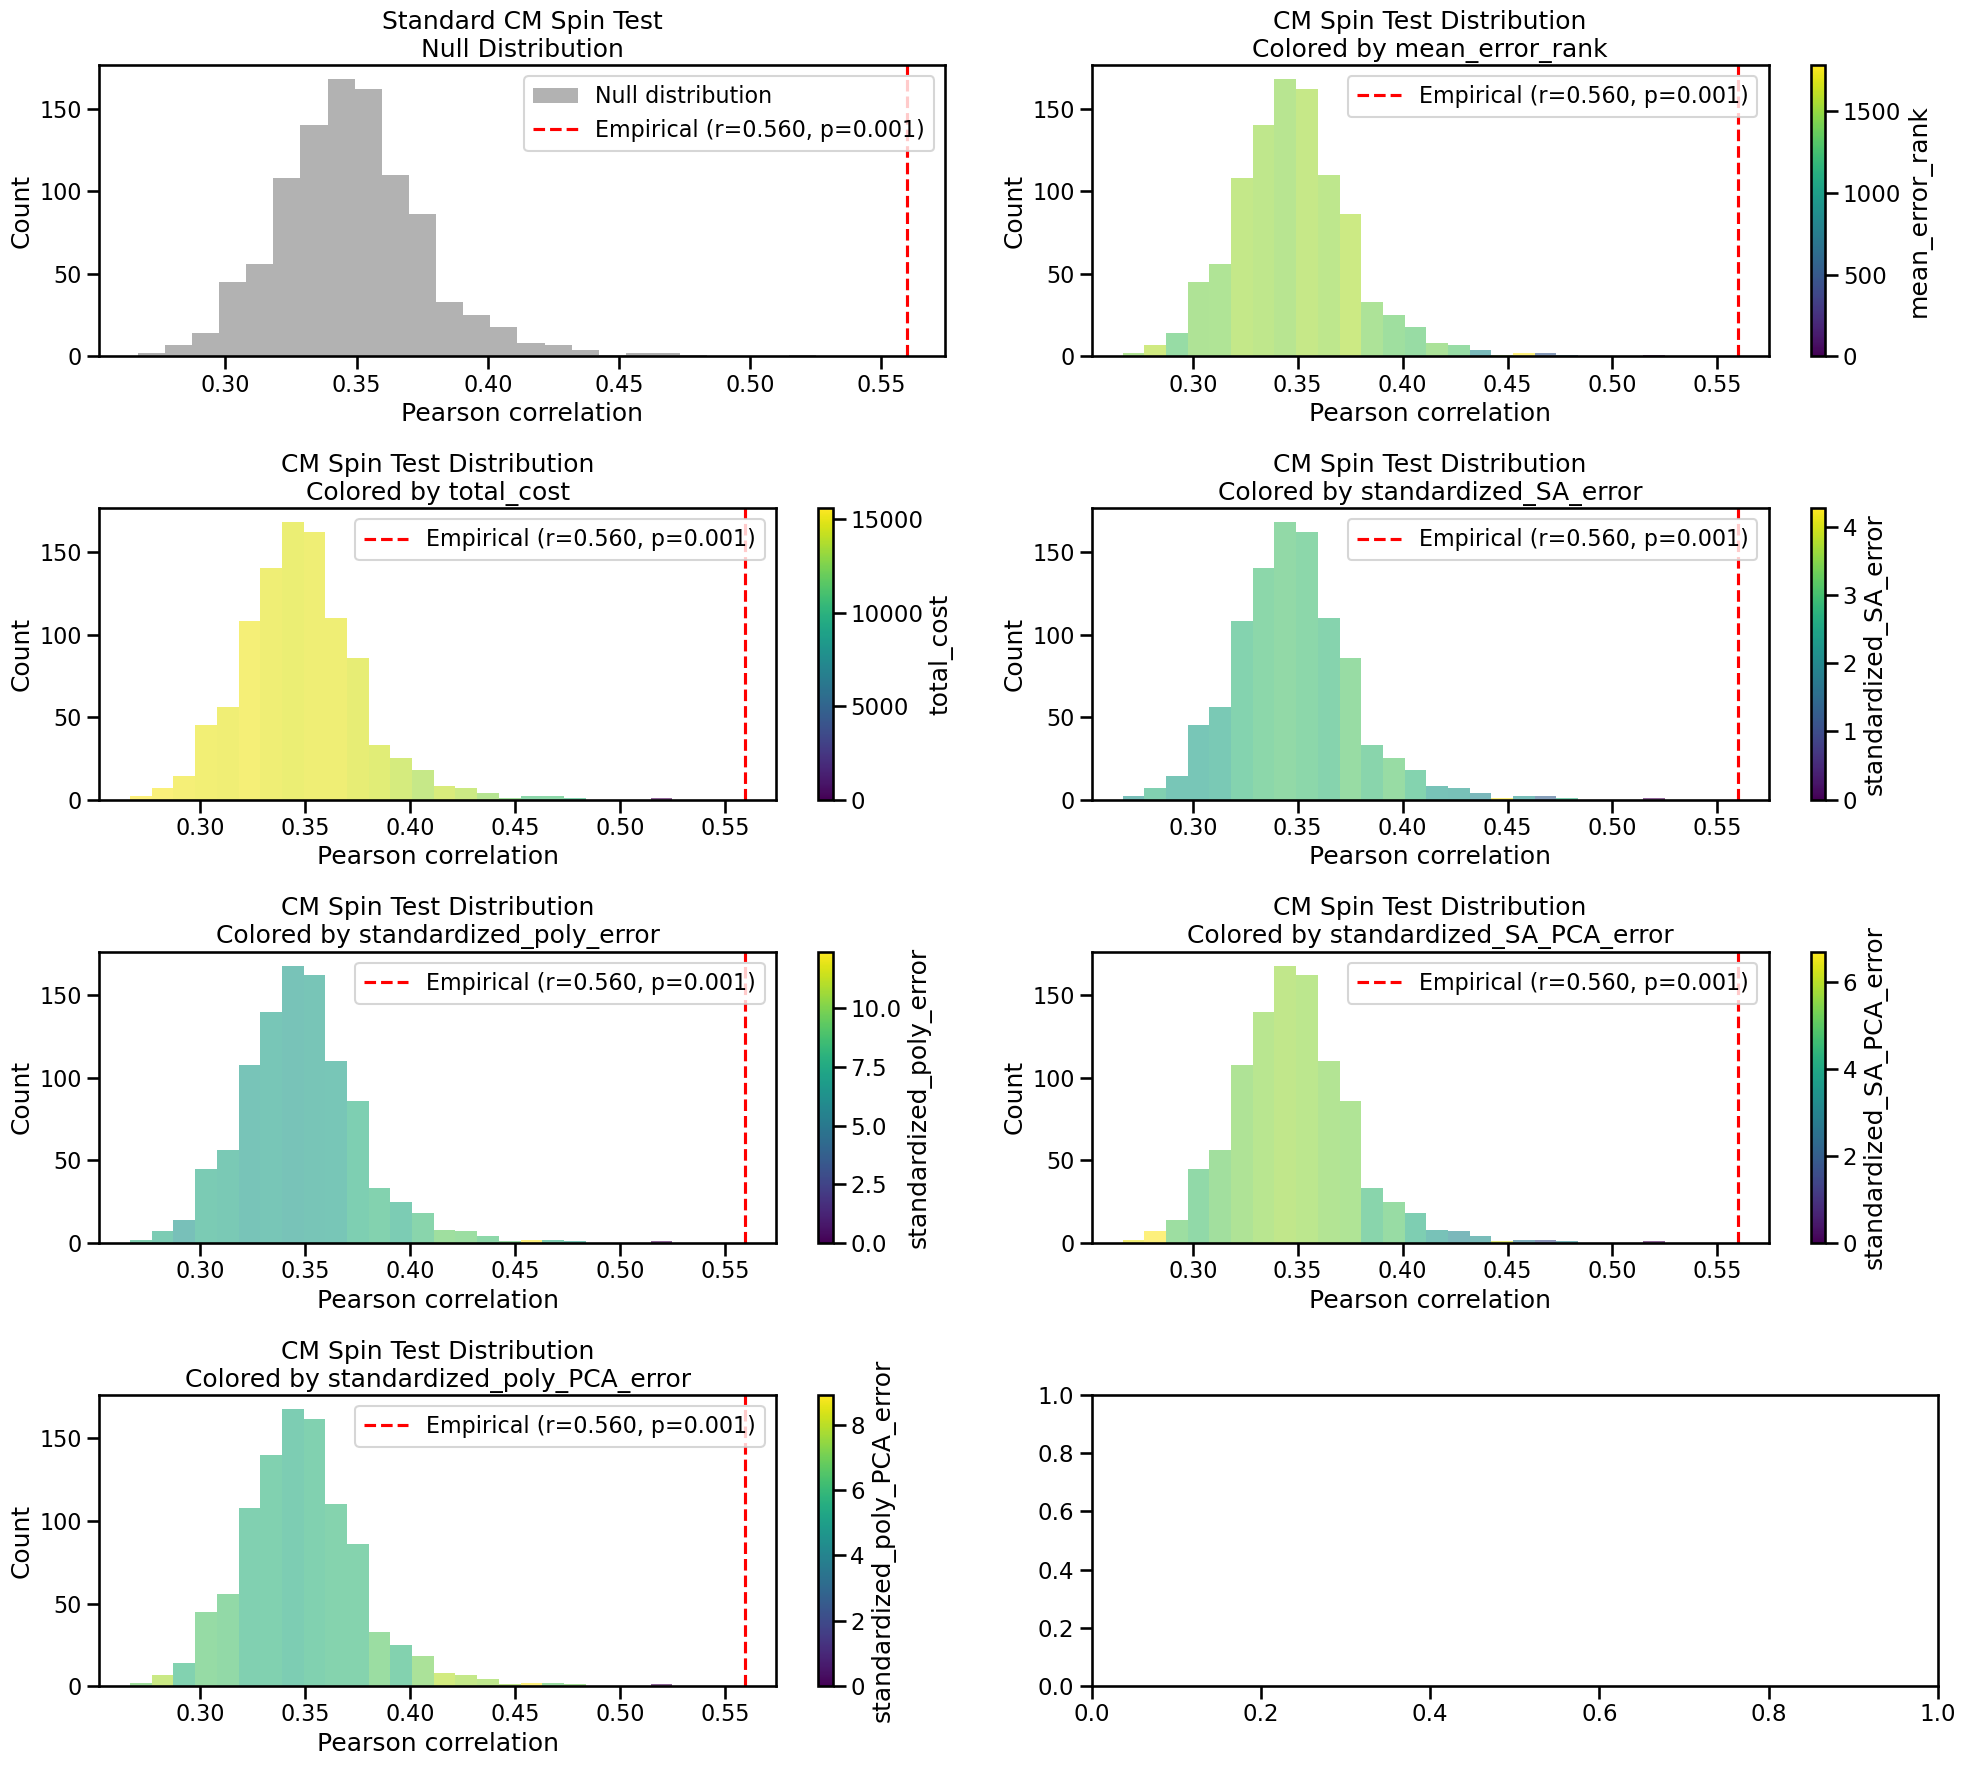

In [48]:
empirical_corr, p_value, null_distribution, error_metrics = run_spin_test_precomputed_colored(
    X=X_pca,
    valid_indices=valid_indices,
    Y_true=Y, 
    spins_df=spins_df_10k,
    model_type='CM',
    sort_spins='mean_error_rank',
    n_perms=1000,
    bins=25
)

permutation: 0
permutation: 50


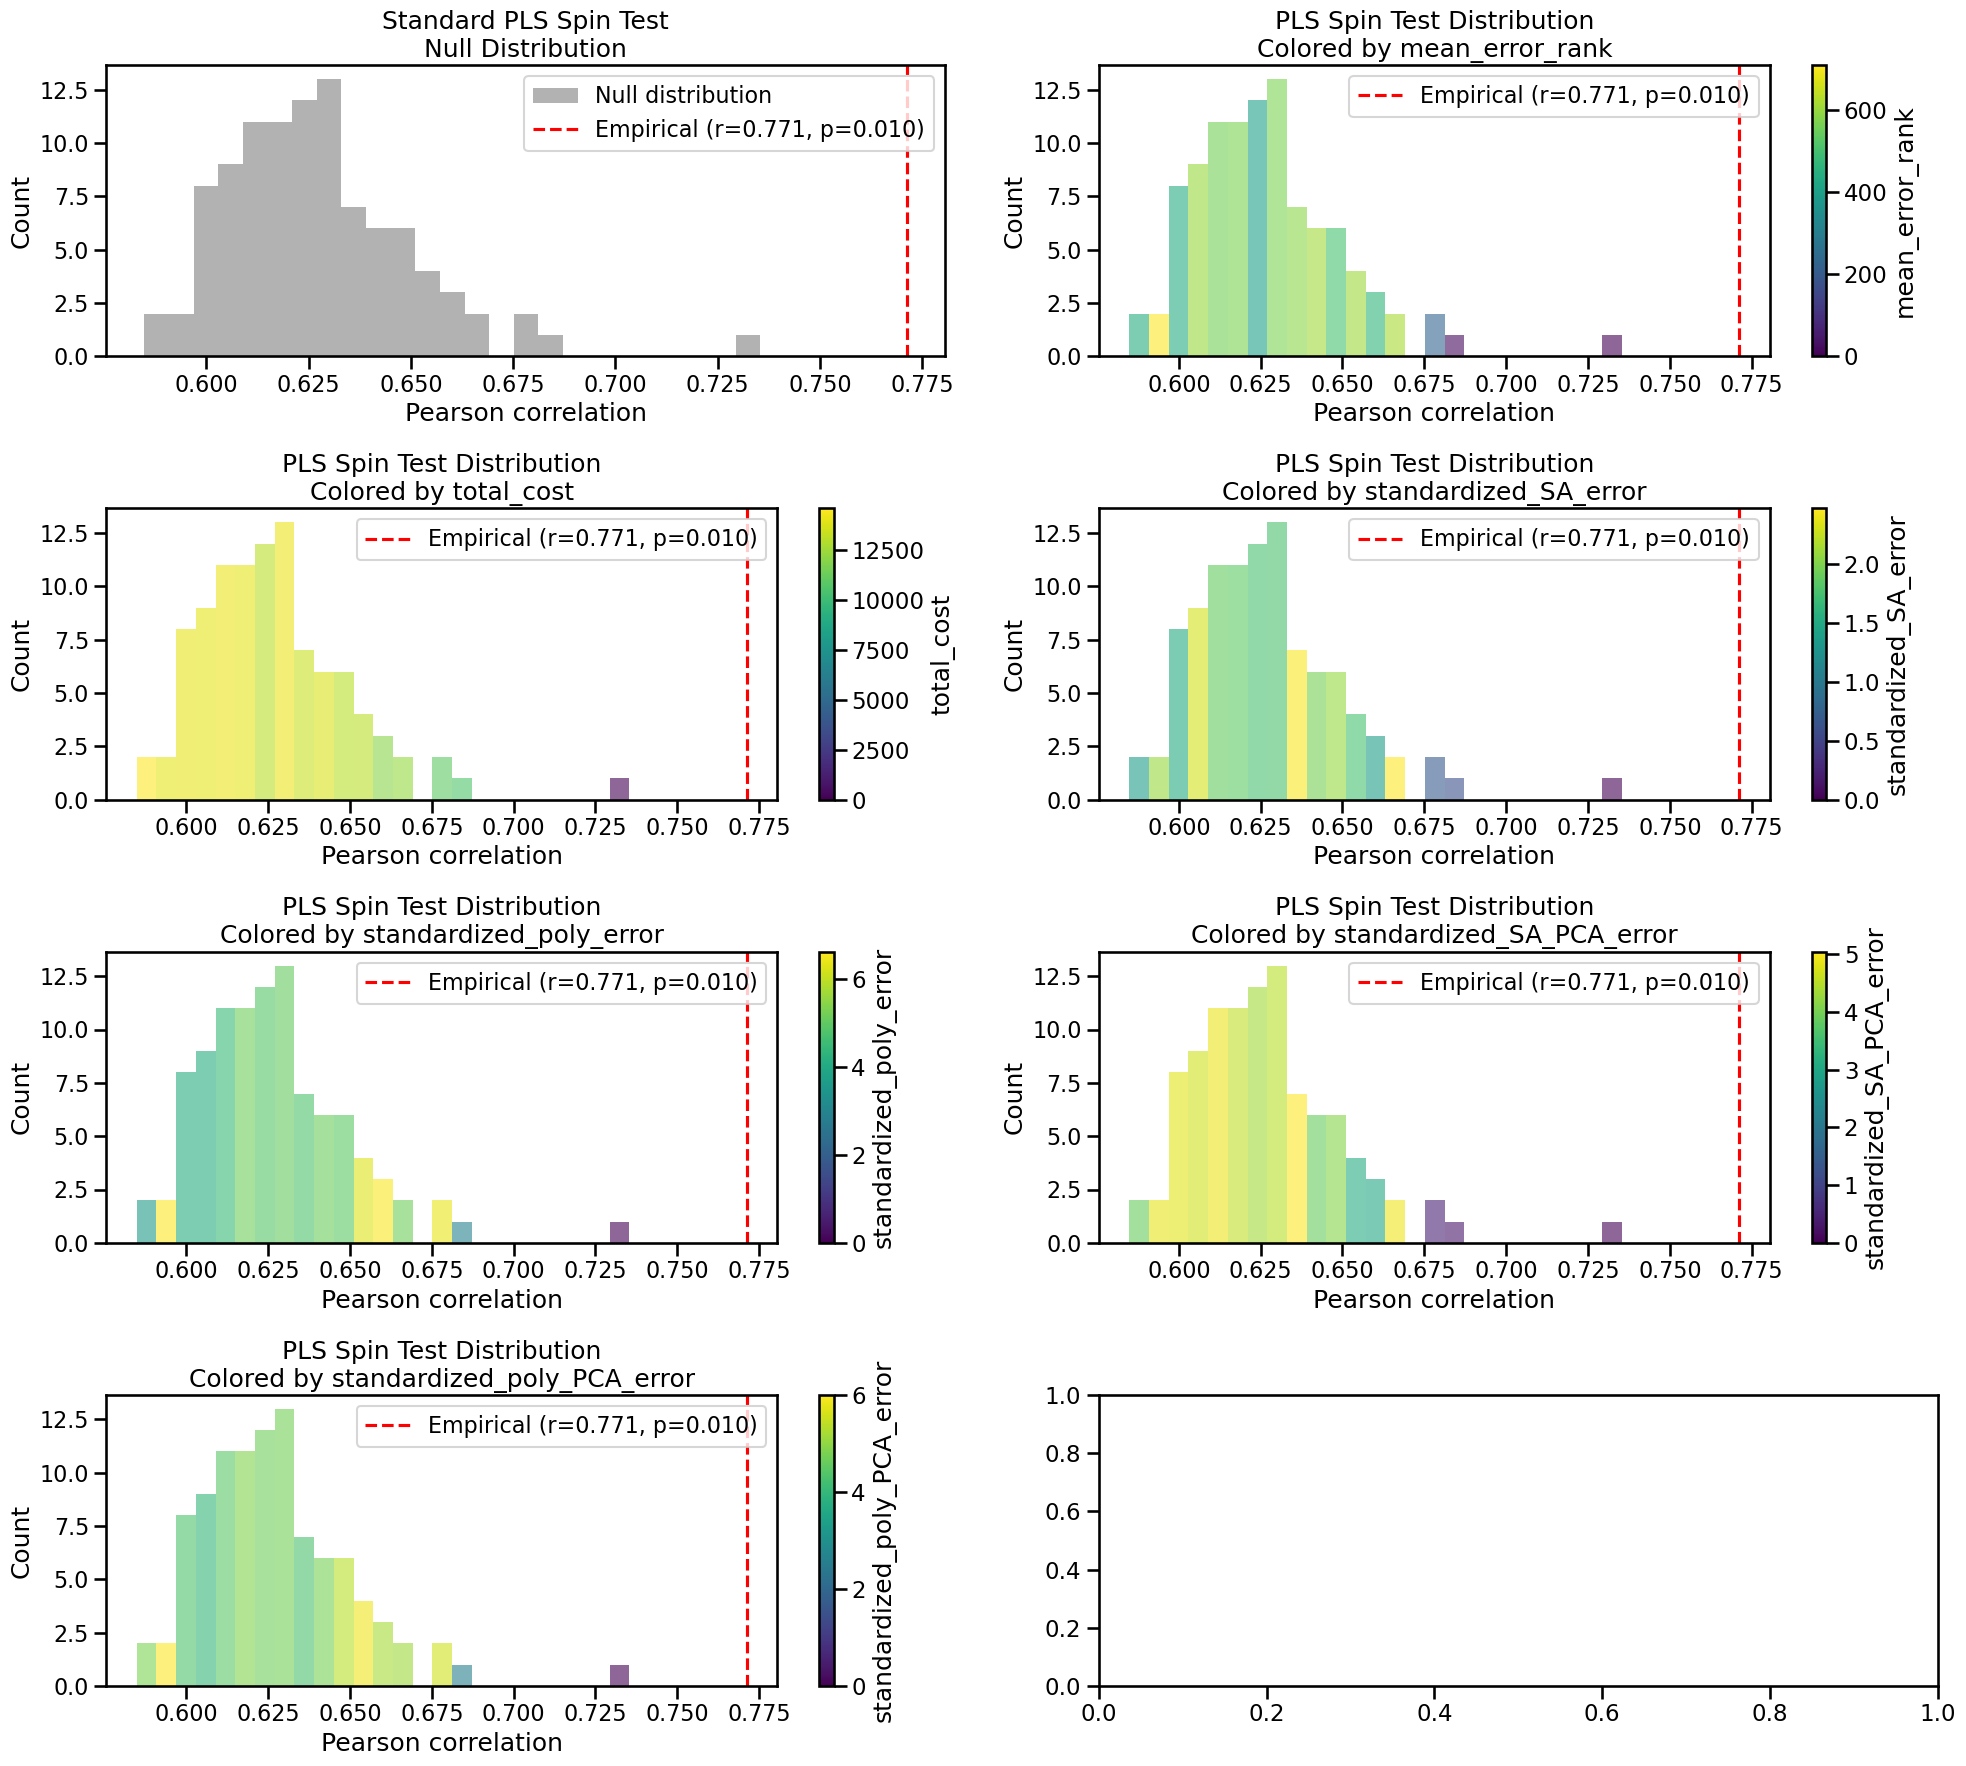

In [47]:
empirical_corr, p_value, null_distribution, error_metrics = run_spin_test_precomputed_colored(
    X=X,
    valid_indices=valid_indices,
    Y_true=Y, 
    spins_df=spins_df_10k,
    model_type='PLS',
    sort_spins='mean_error_rank',
    n_perms=100,
    bins=25
)

#### Compute null distributions for all permutation tests

Generate distribution for all 10k spins

In [ ]:
empirical_corr, p_value, null_distribution_SCM_10k = run_spin_test(
    X=X_pca,
    valid_indices=valid_indices,
    Y_true=Y,
    spins_df=spins_df_10k,
    model_type='CM',
    sort_spins='mean_error_rank',
    n_perms=10000
)


permutation: 0


permutation: 0
permutation: 50
permutation: 100
permutation: 150
permutation: 200
permutation: 250
permutation: 300
permutation: 350
permutation: 400
permutation: 450
permutation: 500
permutation: 550
permutation: 600
permutation: 650
permutation: 700
permutation: 750
permutation: 800
permutation: 850
permutation: 900
permutation: 950
permutation: 1000
permutation: 1050
permutation: 1100
permutation: 1150
permutation: 1200
permutation: 1250
permutation: 1300
permutation: 1350
permutation: 1400
permutation: 1450
permutation: 1500
permutation: 1550
permutation: 1600
permutation: 1650
permutation: 1700
permutation: 1750
permutation: 1800
permutation: 1850
permutation: 1900
permutation: 1950
permutation: 2000
permutation: 2050
permutation: 2100
permutation: 2150
permutation: 2200
permutation: 2250
permutation: 2300
permutation: 2350
permutation: 2400
permutation: 2450
permutation: 2500
permutation: 2550
permutation: 2600
permutation: 2650
permutation: 2700
permutation: 2750
permutation: 28

  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)



permutation: 5800
permutation: 5850
permutation: 5900
permutation: 5950
permutation: 6000
permutation: 6050
permutation: 6100
permutation: 6150
permutation: 6200
permutation: 6250
permutation: 6300
permutation: 6350
permutation: 6400
permutation: 6450
permutation: 6500
permutation: 6550
permutation: 6600
permutation: 6650
permutation: 6700
permutation: 6750
permutation: 6800
permutation: 6850
permutation: 6900
permutation: 6950
permutation: 7000
permutation: 7050
permutation: 7100
permutation: 7150
permutation: 7200
permutation: 7250
permutation: 7300
permutation: 7350
permutation: 7400
permutation: 7450


  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)



permutation: 7500
permutation: 7550
permutation: 7600
permutation: 7650
permutation: 7700
permutation: 7750
permutation: 7800
permutation: 7850
permutation: 7900
permutation: 7950
permutation: 8000
permutation: 8050
permutation: 8100
permutation: 8150
permutation: 8200
permutation: 8250
permutation: 8300
permutation: 8350
permutation: 8400
permutation: 8450
permutation: 8500
permutation: 8550
permutation: 8600
permutation: 8650
permutation: 8700
permutation: 8750
permutation: 8800
permutation: 8850
permutation: 8900
permutation: 8950
permutation: 9000
permutation: 9050
permutation: 9100
permutation: 9150
permutation: 9200
permutation: 9250
permutation: 9300
permutation: 9350
permutation: 9400
permutation: 9450
permutation: 9500
permutation: 9550
permutation: 9600
permutation: 9650
permutation: 9700
permutation: 9750
permutation: 9800
permutation: 9850
permutation: 9900
permutation: 9950


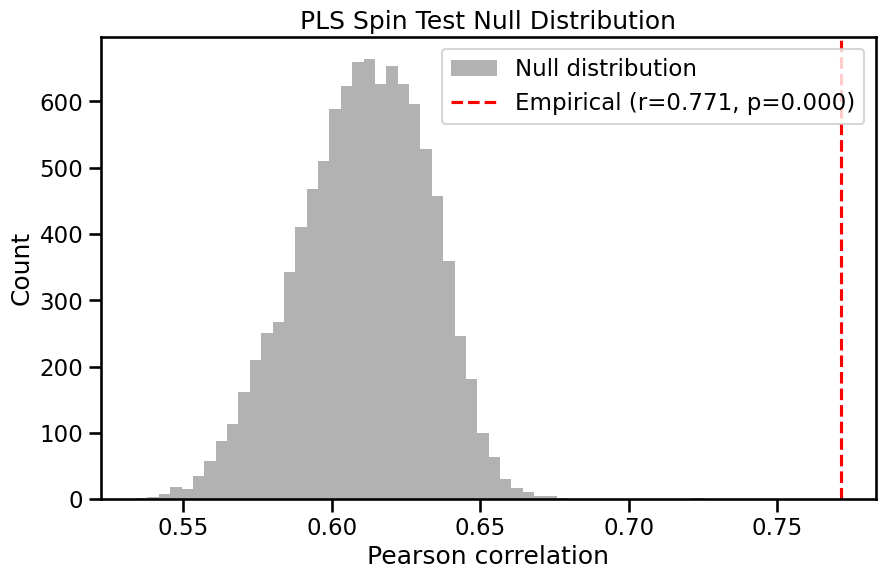

In [20]:
empirical_corr, p_value, null_distribution_PLS_10k = run_spin_test(
    X=X,
    valid_indices=valid_indices,
    Y_true=Y,
    spins_df=spins_df_10k,
    model_type='PLS',
    sort_spins='mean_error_rank',
    n_perms=10000
)

In [23]:
spins_df_10k = spins_df_10k.sort_values('mean_error_rank', ascending=True)
spins_df_10k['pearsonr_SCM'] = null_distribution_SCM_10k
spins_df_10k['pearsonr_PLS'] = null_distribution_PLS_10k
spins_df_10k.to_csv('./data/enigma/10000_null_spins.csv', index=False)

In [24]:
spins_df_10k

,cortical_spins,subcortical_spins,cortical_cost,subcortical_cost,total_cost,mean_error_rank,total_cost_rank,SA_error_rank,poly_error_rank,standardized_SA_error,...,poly_a1,poly_a2,poly_a3,poly_a4,poly_a1_PCA,poly_a2_PCA,poly_a3_PCA,poly_a4_PCA,pearsonr_SCM,pearsonr_PLS
417,"[1, 6, 4, 0, 2, 69, 12, 68, 5, 3, 10, 7, 15, 1...","[0, 33, 2, 29, 1, 5, 6, 7, 8, 3, 10, 11, 12, 1...",9868.096901,612.102793,10480.199694,16.666667,8.0,4.0,38.0,0.609384,...,1.096968,-0.028375,0.000318,-1.088029e-06,1.049116,-0.032066,0.000341,-1.219766e-06,0.364000,0.666082
6245,"[21, 15, 193, 191, 190, 194, 19, 143, 144, 189...","[2, 9, 13, 12, 5, 6, 52, 49, 33, 7, 48, 10, 32...",9643.503872,1295.744937,10939.248809,151.666667,13.0,374.0,68.0,1.591515,...,1.061321,-0.028272,0.000327,-1.137008e-06,1.052804,-0.034917,0.000388,-1.380567e-06,0.344534,0.654514
7911,"[122, 6, 3, 1, 4, 69, 12, 0, 2, 9, 10, 7, 19, ...","[31, 48, 47, 52, 46, 28, 30, 34, 7, 51, 10, 49...",10587.258836,3044.556141,13631.814976,152.333333,441.0,6.0,10.0,0.621569,...,1.082026,-0.029022,0.000340,-1.210387e-06,1.050206,-0.032869,0.000358,-1.300145e-06,0.345113,0.635034
9921,"[175, 172, 137, 117, 170, 136, 113, 138, 134, ...","[53, 55, 46, 49, 54, 48, 5, 33, 4, 51, 32, 31,...",9722.312520,2569.249866,12291.562385,181.666667,82.0,340.0,123.0,1.547915,...,1.074919,-0.030991,0.000379,-1.374732e-06,1.043412,-0.034916,0.000391,-1.391307e-06,0.356331,0.627593
5302,"[0, 1, 2, 6, 4, 5, 12, 7, 8, 3, 9, 11, 15, 92,...","[53, 55, 54, 48, 49, 50, 13, 9, 6, 52, 2, 47, ...",8802.011771,2648.851327,11450.863098,215.333333,26.0,5.0,615.0,0.609793,...,1.025928,-0.025585,0.000291,-1.015320e-06,0.997005,-0.028756,0.000293,-1.029769e-06,0.390174,0.679359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9064,"[159, 128, 164, 157, 161, 163, 158, 129, 160, ...","[50, 55, 53, 52, 49, 48, 43, 34, 32, 54, 0, 51...",15133.379157,3055.667316,18189.046474,9577.000000,9737.0,9736.0,9258.0,8.016635,...,0.850472,-0.017753,0.000168,-4.127311e-07,0.819769,-0.021002,0.000160,-3.131510e-07,0.329802,0.597501
1230,"[44, 47, 42, 49, 104, 174, 184, 103, 141, 46, ...","[10, 46, 55, 50, 28, 51, 32, 31, 42, 52, 8, 54...",15090.569712,2961.466725,18052.036437,9587.000000,9571.0,9314.0,9876.0,7.709224,...,0.831457,-0.015476,0.000130,-2.593521e-07,0.779299,-0.018217,0.000125,-2.139854e-07,0.350628,0.598435
8040,"[76, 77, 79, 74, 72, 81, 129, 80, 94, 27, 128,...","[7, 54, 43, 53, 6, 8, 13, 46, 12, 34, 48, 49, ...",14793.927720,3024.581674,17818.509395,9590.666667,9200.0,9803.0,9769.0,8.094710,...,0.826775,-0.016184,0.000146,-3.293848e-07,0.796226,-0.020708,0.000165,-3.566246e-07,0.348113,0.598309
9440,"[63, 66, 67, 83, 62, 53, 30, 54, 111, 84, 144,...","[33, 4, 55, 51, 32, 5, 28, 42, 43, 50, 13, 54,...",15577.466231,2429.806374,18007.272605,9658.000000,9513.0,9974.0,9487.0,8.494684,...,0.839477,-0.017391,0.000162,-3.843176e-07,0.832319,-0.022791,0.000189,-4.314851e-07,0.317612,0.578567


Generate distribution for all spatial random permutations

permutation: 0
permutation: 50
permutation: 100
permutation: 150
permutation: 200
permutation: 250
permutation: 300
permutation: 350
permutation: 400
permutation: 450
permutation: 500
permutation: 550
permutation: 600
permutation: 650
permutation: 700
permutation: 750
permutation: 800
permutation: 850
permutation: 900
permutation: 950


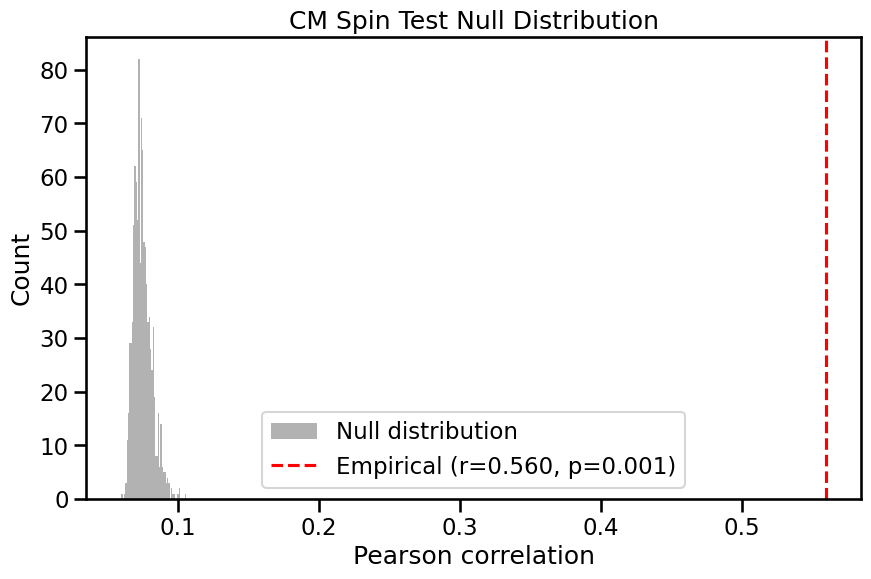

In [49]:
empirical_corr, p_value, null_distribution_SCM_spatial_random = run_spin_test(
    X=X_pca,
    valid_indices=valid_indices,
    Y_true=Y,
    spins_df=spins_df_spatial_random,
    model_type='CM',
    sort_spins=None,
    n_perms=1000
)

permutation: 0
permutation: 50
permutation: 100
permutation: 150
permutation: 200
permutation: 250
permutation: 300
permutation: 350
permutation: 400
permutation: 450
permutation: 500
permutation: 550
permutation: 600
permutation: 650
permutation: 700
permutation: 750
permutation: 800
permutation: 850
permutation: 900
permutation: 950


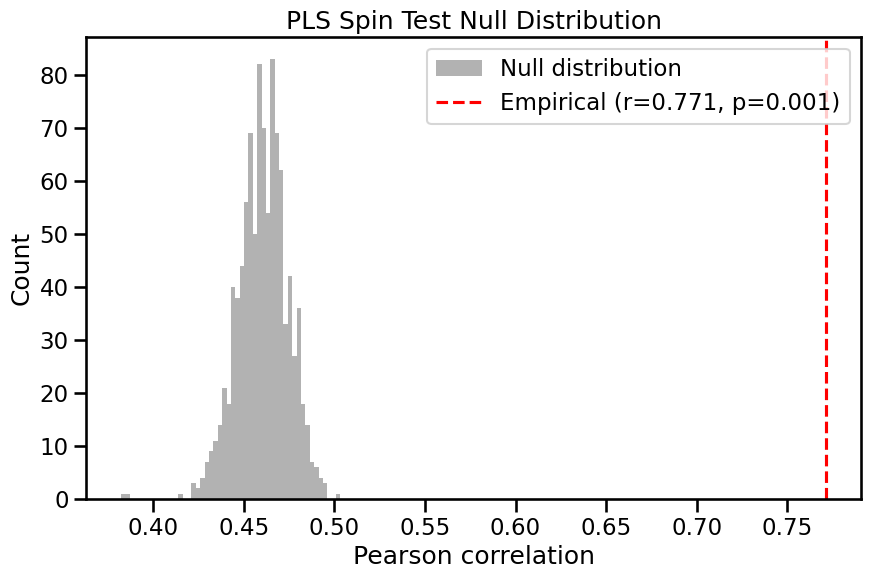

In [50]:

empirical_corr, p_value, null_distribution_PLS_spatial_random = run_spin_test(
    X=X,
    valid_indices=valid_indices,
    Y_true=Y,
    spins_df=spins_df_spatial_random,
    model_type='PLS',
    sort_spins=None,
    n_perms=1000
)

In [54]:
spins_df_spatial_random['pearsonr_SCM'] = null_distribution_SCM_spatial_random
spins_df_spatial_random['pearsonr_PLS'] = null_distribution_PLS_spatial_random
spins_df_spatial_random

#spins_df_spatial_random.to_csv('./data/enigma/1000_spatial_random_spins.csv', index=False)

Generate distribution for true random permutations

permutation: 0
permutation: 50
permutation: 100
permutation: 150
permutation: 200
permutation: 250
permutation: 300
permutation: 350
permutation: 400
permutation: 450
permutation: 500
permutation: 550
permutation: 600
permutation: 650
permutation: 700
permutation: 750
permutation: 800
permutation: 850
permutation: 900
permutation: 950


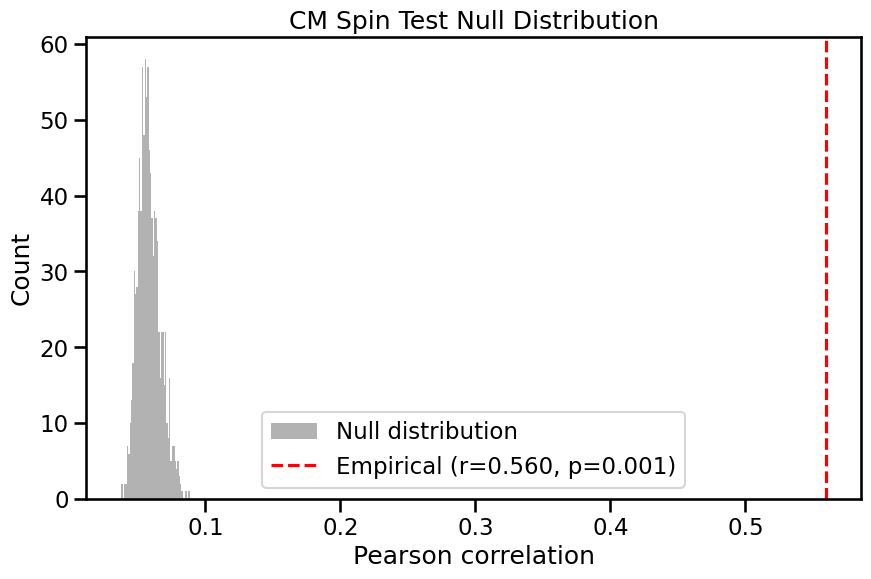

In [55]:
empirical_corr, p_value, null_distribution_SCM_random = run_spin_test_random(
    X=X_pca,
    valid_indices=valid_indices,
    Y_true=Y,
    spins_df=spins_df_random,
    model_type='CM',
    n_perms=1000
)

permutation: 0


permutation: 50
permutation: 100
permutation: 150
permutation: 200
permutation: 250
permutation: 300
permutation: 350
permutation: 400
permutation: 450
permutation: 500
permutation: 550
permutation: 600
permutation: 650
permutation: 700
permutation: 750
permutation: 800
permutation: 850
permutation: 900
permutation: 950


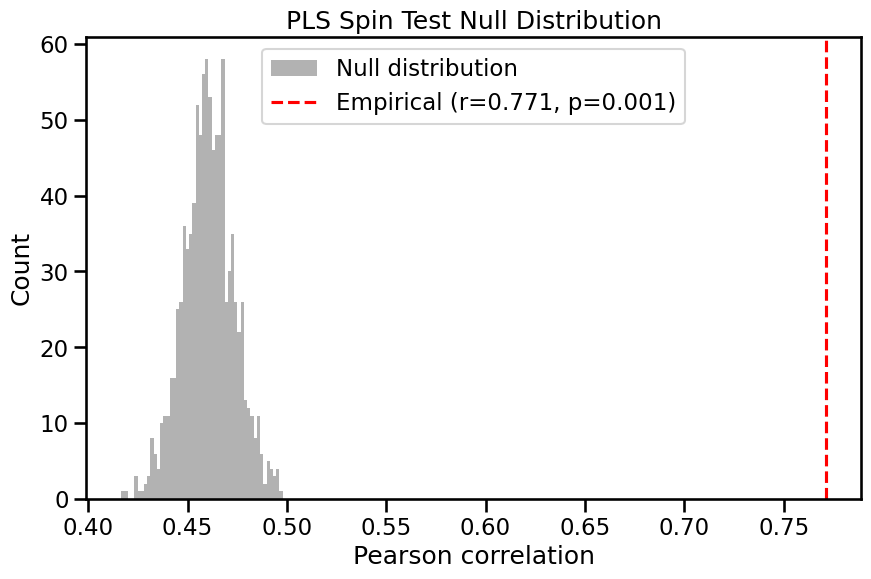

In [56]:
empirical_corr, p_value, null_distribution_PLS_random = run_spin_test_random(
    X=X,
    valid_indices=valid_indices,
    Y_true=Y,
    spins_df=spins_df_random,
    model_type='PLS',
    n_perms=1000
)

In [57]:
spins_df_random['pearsonr_SCM'] = null_distribution_SCM_random
spins_df_random['pearsonr_PLS'] = null_distribution_PLS_random
#spins_df_random.to_csv('./data/enigma/1000_true_random_spins.csv', index=False)

### Compare distributions for different permutation types

In [58]:
spins_df_10k = pd.read_csv('./data/enigma/10000_null_spins.csv')
spins_df_spatial_random = pd.read_csv('./data/enigma/1000_spatial_random_spins.csv')
spins_df_random = pd.read_csv('./data/enigma/1000_true_random_spins.csv')

In [59]:
# Sort spins_df_10k by mean_error_rank
spins_df_10k = spins_df_10k.sort_values('mean_error_rank', ascending=True)
spins_10k_SCM_null_dist = spins_df_10k['pearsonr_SCM'].values
spins_10k_PLS_null_dist = spins_df_10k['pearsonr_PLS'].values

# Get top 1k spins based on mean error rank
spins_10k_top1k_SCM_null_dist = spins_10k_SCM_null_dist[:1000]
spins_10k_top1k_PLS_null_dist = spins_10k_PLS_null_dist[:1000]

# Randomly sample 1k spins from remaining 9k
remaining_indices = np.arange(9000, 10000)
random_indices = np.random.choice(remaining_indices, size=1000, replace=False)
spins_10k_random1k_SCM_null_dist = spins_10k_SCM_null_dist[random_indices]
spins_10k_random1k_PLS_null_dist = spins_10k_PLS_null_dist[random_indices]

spins_spatial_random_SCM_null_dist = spins_df_spatial_random['pearsonr_SCM'].values
spins_spatial_random_PLS_null_dist = spins_df_spatial_random['pearsonr_PLS'].values
spins_random_SCM_null_dist = spins_df_random['pearsonr_SCM'].values
spins_random_PLS_null_dist = spins_df_random['pearsonr_PLS'].values

In [60]:
def plot_null_distributions(null_dists, labels, colors, model_type='SCM', fontsize=14):
    """
    Plot multiple null distributions with empirical value
    
    Parameters:
    -----------
    empirical_corr : float
        Empirical correlation value to plot
    null_dists : list of arrays
        List of null distribution arrays to plot
    labels : list of str
        Labels for each null distribution
    colors : list of str
        Colors for each null distribution
    model_type : str
        'SCM' or 'PLS' - which model results to plot
    fontsize : int
        Font size for plot text elements
    """
    plt.figure(figsize=(10, 6))

    if model_type == 'SCM':
        empirical_corr, _, _ = run_spin_test(
            X=X_pca,
            valid_indices=valid_indices,
            Y_true=Y,
            spins_df=spins_df_1k,
            model_type=model_type,
            sort_spins='mean_error_rank',
            n_perms=1
        )
    elif model_type == 'PLS':
       empirical_corr, _, _ = run_spin_test(
            X=X,
            valid_indices=valid_indices,
            Y_true=Y,
            spins_df=spins_df_1k,
            model_type=model_type,
            sort_spins='mean_error_rank',
            n_perms=1
        )
    
    # Plot each null distribution
    for dist, label, color in zip(null_dists, labels, colors):
        mean_val = np.mean(dist)
        plt.hist(dist, bins=50, alpha=0.4, color=color, 
                label=f'{label} (mean={mean_val:.3f})', density=True)
        
    # Add empirical line
    plt.axvline(empirical_corr, color='red', linestyle='--',
                label=f'Empirical (r={empirical_corr:.3f})')
    
    plt.xlabel('Pearson correlation', fontsize=fontsize)
    plt.ylabel('Density', fontsize=fontsize)
    plt.title(f'{model_type} Spin Test Null Distributions', fontsize=fontsize)
    plt.legend(fontsize=fontsize-2)
    plt.tick_params(labelsize=fontsize-2)
    plt.show()

permutation: 0


<Figure size 1000x600 with 0 Axes>

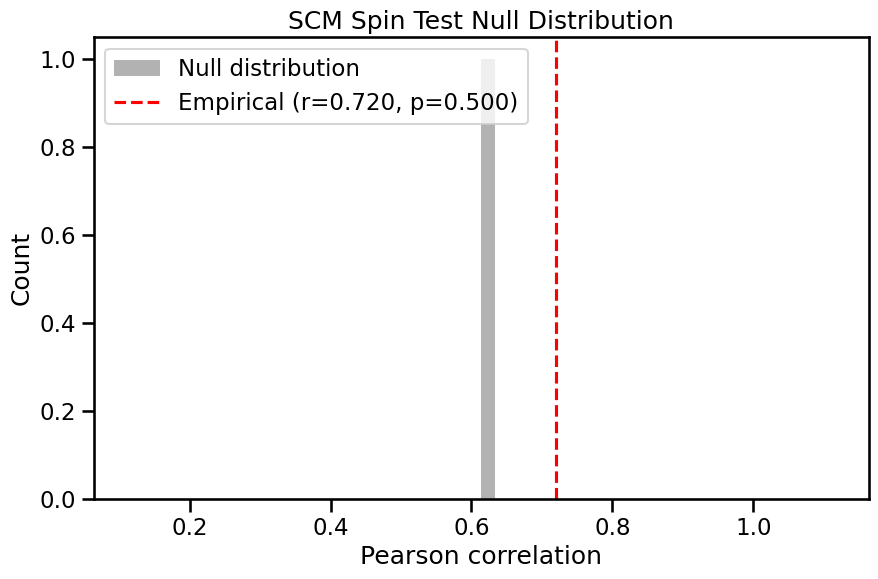

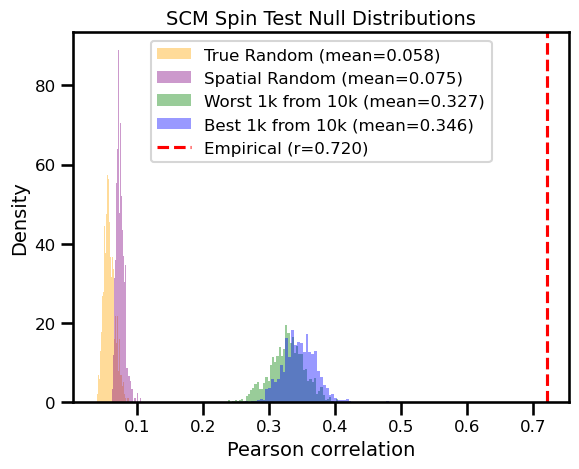

In [61]:
# Plot SCM distributions
plot_null_distributions(
    [spins_random_SCM_null_dist,
     spins_spatial_random_SCM_null_dist,
     spins_10k_random1k_SCM_null_dist,
     spins_10k_top1k_SCM_null_dist],
    ['True Random', 'Spatial Random', 'Worst 1k from 10k', 'Best 1k from 10k'],
    ['orange', 'purple', 'green', 'blue'],
    model_type='SCM'
)

permutation: 0


<Figure size 1000x600 with 0 Axes>

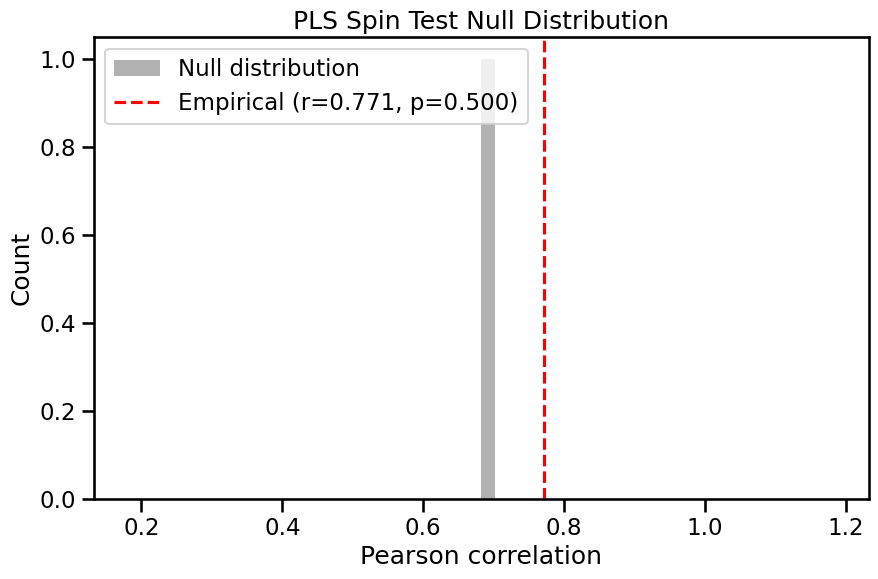

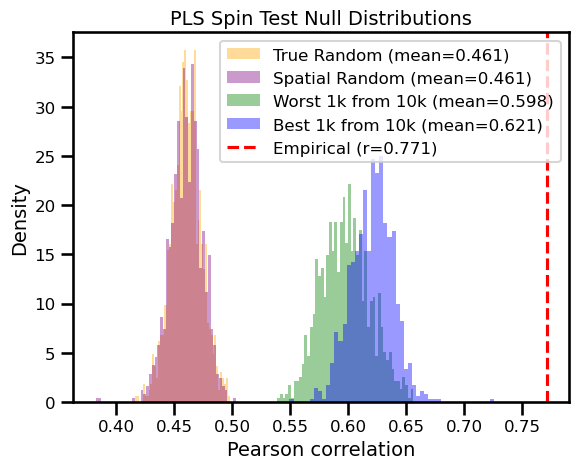

In [62]:

# Plot SCM distributions
plot_null_distributions(
    [spins_random_PLS_null_dist,
     spins_spatial_random_PLS_null_dist,
     spins_10k_random1k_PLS_null_dist,
     spins_10k_top1k_PLS_null_dist],
    ['True Random', 'Spatial Random', 'Worst 1k from 10k', 'Best 1k from 10k'],
    ['orange', 'purple', 'green', 'blue'],
    model_type='PLS'
)

In [74]:
def plot_top_10_vs_full_distribution(spins_df_10k, spins_10k_SCM_null_dist, spins_10k_PLS_null_dist, X_pca, X, Y, valid_indices):
    """
    Plot comparison of full null distribution vs top 10 spins for both SCM and PLS models.
    
    Args:
        spins_df_10k: DataFrame containing spin results
        spins_10k_SCM_null_dist: Array of SCM null correlations
        spins_10k_PLS_null_dist: Array of PLS null correlations 
        X_pca: PCA-transformed gene expression data
        X: Raw gene expression data
        Y: Connectivity matrix
        valid_indices: Boolean mask of valid indices
    """
    # Sort spins_df_10k by mean_error_rank and display top 10 rows
    spins_df_10k = spins_df_10k.sort_values('mean_error_rank')

    # Get top 10 spins by mean error rank
    top_10_SCM = spins_df_10k['pearsonr_SCM'].iloc[:10].mean()
    top_10_PLS = spins_df_10k['pearsonr_PLS'].iloc[:10].mean()

    # Get distribution means
    mean_SCM = np.mean(spins_10k_SCM_null_dist)
    mean_PLS = np.mean(spins_10k_PLS_null_dist)

    # Get empirical correlations
    empirical_SCM_corr, _, _ = run_spin_test(
        X=X_pca,
        valid_indices=valid_indices,
        Y_true=Y,
        spins_df=spins_df_10k,
        model_type='SCM',
        sort_spins='mean_error_rank',
        n_perms=1
    )

    empirical_PLS_corr, _, _ = run_spin_test(
        X=X,
        valid_indices=valid_indices,
        Y_true=Y,
        spins_df=spins_df_10k,
        model_type='PLS',
        sort_spins='mean_error_rank',
        n_perms=1
    )

    # Plot SCM distribution
    plt.figure(figsize=(10, 6))
    plt.hist(spins_10k_SCM_null_dist, bins=50, alpha=0.4, color='blue', 
             label=f'Full Distribution (n=10000)')
    plt.axvline(top_10_SCM, color='red', linestyle='--',
                label=f'Top 10 Mean (r={top_10_SCM:.3f})')
    plt.axvline(mean_SCM, color='black', linestyle='--',
                label=f'Distribution Mean (r={mean_SCM:.3f})')
    plt.axvline(empirical_SCM_corr, color='green', linestyle='--',
                label=f'Empirical (r={empirical_SCM_corr:.3f})')
    plt.xlabel('Pearson correlation', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.title('SCM Full Distribution vs Top 10 Mean', fontsize=14)
    plt.legend(fontsize=12)
    plt.tick_params(labelsize=12)
    plt.show()

    # Plot PLS distribution
    plt.figure(figsize=(10, 6))
    plt.hist(spins_10k_PLS_null_dist, bins=50, alpha=0.4, color='green',
             label=f'Full Distribution (n=10000)')
    plt.axvline(top_10_PLS, color='red', linestyle='--',
                label=f'Top 10 Mean (r={top_10_PLS:.3f})')
    plt.axvline(mean_PLS, color='black', linestyle='--',
                label=f'Distribution Mean (r={mean_PLS:.3f})')
    plt.axvline(empirical_PLS_corr, color='blue', linestyle='--',
                label=f'Empirical (r={empirical_PLS_corr:.3f})')
    plt.xlabel('Pearson correlation', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.title('PLS Full Distribution vs Top 10 Mean', fontsize=14)
    plt.legend(fontsize=12)
    plt.tick_params(labelsize=12)
    plt.show()


permutation: 0


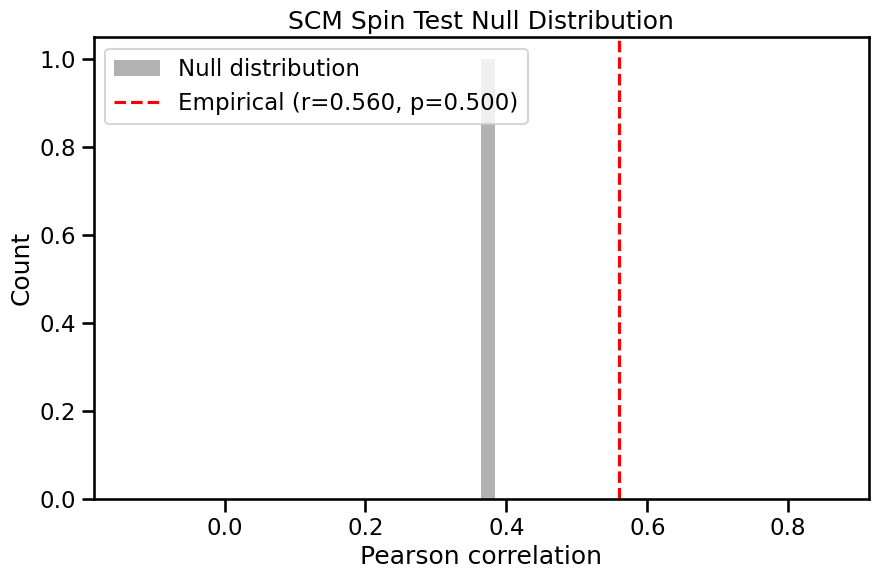

permutation: 0


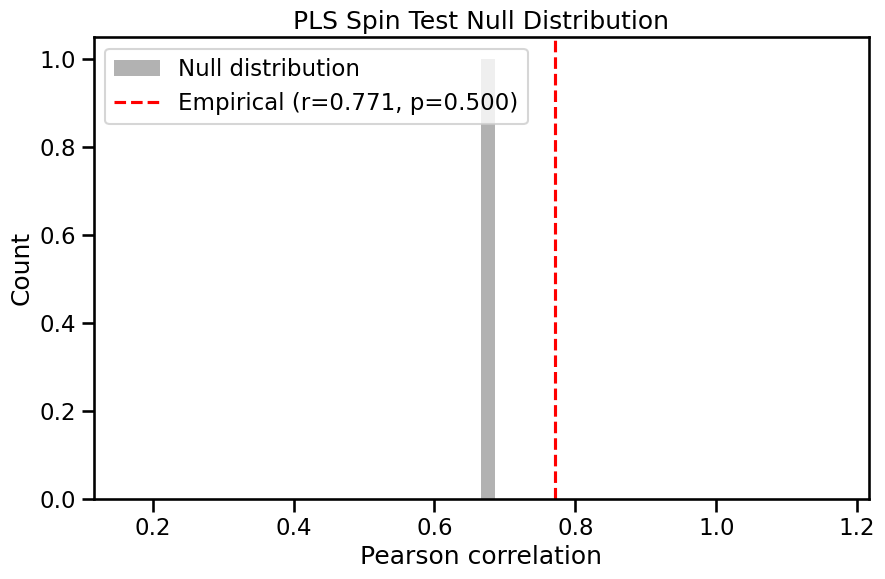

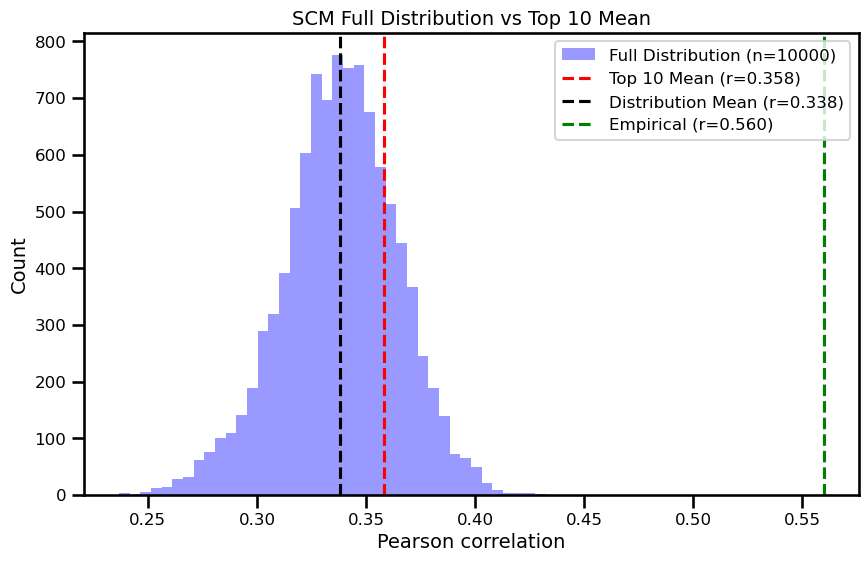

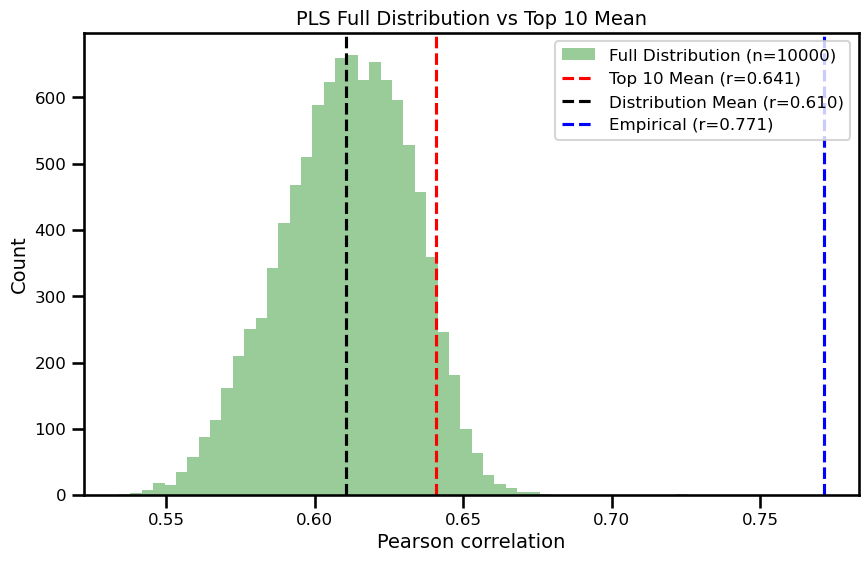

In [77]:
plot_top_10_vs_full_distribution(spins_df_10k, spins_10k_SCM_null_dist, spins_10k_PLS_null_dist, X_pca, X, Y, valid_indices)

In [79]:
load_transcriptome(parcellation='S400', omit_subcortical=False, hemisphere='both', impute_strategy='mirror_interpolate', sort_genes='expression', null_model='spin', random_seed=42)






Spinning gene expression
Spin index for seed 42: 9


array([[0.15136387, 0.187843  , 0.13702233, ..., 0.82175135, 0.87288001,
        0.87122648],
       [0.19016599, 0.3056109 , 0.38667427, ..., 0.73830012, 0.80667109,
        0.72479233],
       [0.13215955, 0.22330828, 0.14797115, ..., 0.83984844, 0.88073275,
        0.88292539],
       ...,
       [0.11170865, 0.16002888, 0.20872255, ..., 0.89850029, 0.88463182,
        0.88593664],
       [0.16635981, 0.27038418, 0.2244792 , ..., 0.89132107, 0.88654325,
        0.90813563],
       [0.09754496, 0.1912747 , 0.49564139, ..., 0.86276674, 0.93376185,
        0.87924573]])